## Initialize

In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# Some parameters to describe the geometry:
eps = 13    # dielectric constant of waveguide
w = 1.2     # width of waveguide
r = 0.36    # radius of holes

# The cell dimensions
sy = 12     # size of cell in y direction (perpendicular to wvg.)
dpml = 4    # PML thickness (y direction only!), the value in the tutorial is 1
cell = mp.Vector3(1, sy+2*dpml)

b = mp.Block(size=mp.Vector3(mp.inf, w, mp.inf), material=mp.Medium(epsilon=eps))
c = mp.Cylinder(radius=r)

resolution=20

pml_layers = [mp.PML(dpml, direction=mp.Y)]

In [6]:
fcen = 0.1643177236748588  # pulse center frequency, the value in the tutorial is 0.25
df = 0.02     # pulse freq. width: large df = short impulse, the value in the tutorial is 1.5

src = [mp.Source(mp.GaussianSource(fcen, fwidth=2*df), component=mp.Hz,
                center=mp.Vector3(0.234,0))]

In [7]:
sym = [mp.Mirror(direction=mp.Y, phase=-1)]
geometry = [b,c]
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    boundary_layers=pml_layers,
                    sources=src,
                    symmetries=sym,
                    resolution=resolution)

## Band structure

In [8]:
sim.k_point = mp.Vector3(0.3)
h = mp.Harminv(mp.Hz, mp.Vector3(-0.11), fcen, df)
sim.run(mp.at_beginning(mp.output_epsilon),
        mp.after_sources(h),
        until_after_sources = 2000)

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00100899 s
Working in 2D dimensions.
Computational cell is 1 x 20 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0229962 s
-----------
Meep: using complex fields.
creating output file "./eps-000000.00.h5"...
Meep progress: 1180.125/2250.0 = 52.5% done in 4.0s, 3.6s to go
on time step 47238 (time=1180.95), 8.46778e-05 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.1643177137174207, 4.24073957526926e-15, -19373709561850.137, 40.768472402878864, 38.32314913486321-13.906997607367627i, 9.674840332415916e-15+0.0i
run 0 finished at t = 2250.0 (

In [5]:
%%capture
k = []
w = []
Q = []
nqm = []
nqml = []
kxlist = np.linspace(0, 0.5, 21)
for kx in kxlist:
    sim.k_point = mp.Vector3(kx)
    h = mp.Harminv(mp.Hz, mp.Vector3(0.1234), fcen, df)
    sim.run(mp.at_beginning(mp.output_epsilon),
        mp.after_sources(h),
        until_after_sources=2000)
    wp = [m.freq for m in h.modes]
    Qp = [m.Q for m in h.modes]
    kp = [kx]*len(wp)
    for q in Qp:      #the following loop check if q is negative and record the negative mode in nqml
        if q<0:
            i = Qp.index(q)
            nqm = nqm + [i]
            nqml.append([kp[i],wp[i]])
    for i in sorted(nqm, reverse=True):  #the following loop remove the modes with negative q
        kp.pop(i)
        wp.pop(i)
        Qp.pop(i)
    nqm=[]
    k = k + kp
    w = w + wp
    Q = Q + Qp
    sim.reset_meep()

In [6]:
nqml

[[0.0, 0.6352147646177705],
 [0.0, 0.8170552025392338],
 [0.0, 0.9422585970921457],
 [0.025, 0.024989949082660994],
 [0.025, 0.9778639155996197],
 [0.05, 0.049611945008053],
 [0.07500000000000001, 0.07379776145539463],
 [0.1, 0.09104127739536899],
 [0.15000000000000002, 0.1169198934731357],
 [0.225, 0.14236073821249845],
 [0.25, 0.7484571508416413],
 [0.275, 0.1572178608036085],
 [0.30000000000000004, 0.1643177236748588],
 [0.30000000000000004, 0.2993783340075774],
 [0.325, 0.1711496646487541],
 [0.35000000000000003, 0.1776264656103236],
 [0.35000000000000003, 0.3206676037921495],
 [0.375, 0.3177667852281811],
 [0.375, 0.3739976339449734],
 [0.4, 0.1889818688504977],
 [0.4, 0.3139761984071183],
 [0.4, 0.3951660841974603],
 [0.42500000000000004, 0.3104007078932037],
 [0.45, 0.42661040706141523],
 [0.47500000000000003, 0.19915244196665471],
 [0.47500000000000003, 0.3056568926950877],
 [0.47500000000000003, 0.4359578037968216],
 [0.5, 0.43960620765439234],
 [0.5, 0.45820009623606905]]

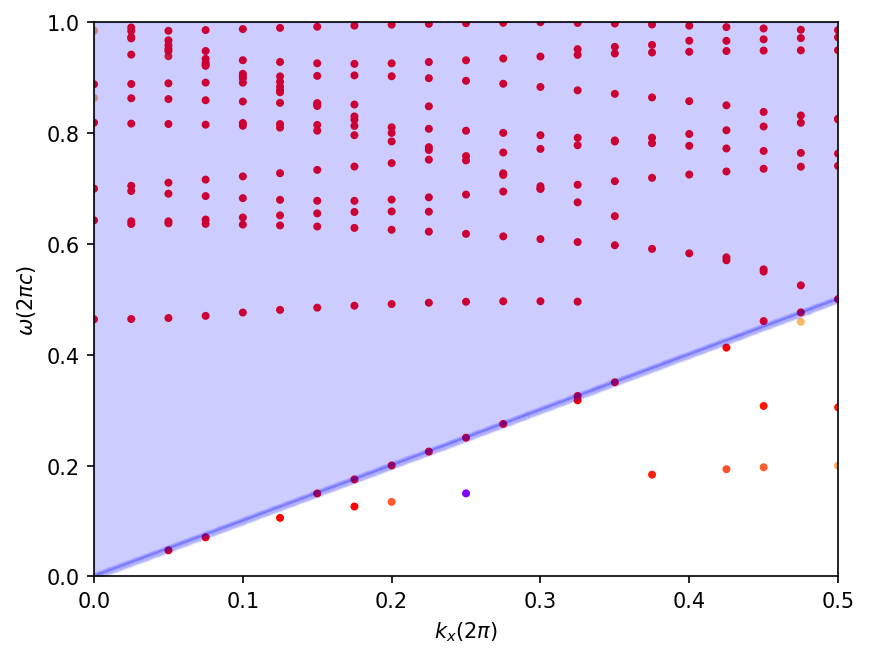

In [24]:
kx = np.linspace(0, 1, 1000)
plt.figure(dpi=150)
plt.scatter(k, w, c=Q, cmap='rainbow_r', s=8)
plt.scatter(kx, kx, marker='.', color='b', alpha=0.05)
plt.fill_betweenx(kx, 0, kx, color='b', alpha=0.2)
plt.xlim([0,0.5])
plt.ylim([0,1.0])
plt.xlabel('$k_x(2\pi)$')
plt.ylabel('$\omega(2\pi c)$')
plt.savefig('wvg_band.png')
plt.show()

In [60]:
kx = 0.4
sim.k_point = mp.Vector3(kx)
h = mp.Harminv(mp.Hz, mp.Vector3(0.1234), fcen, df)

sim.run(mp.at_beginning(mp.output_epsilon),
        mp.after_sources(h),
        until_after_sources=300)

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00166202 s
Working in 2D dimensions.
Computational cell is 1 x 12 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0169079 s
-----------
Meep: using complex fields.
creating output file "./eps-000000.00.h5"...
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.1889817702712683, -3.2186322829265657e-09, 29357465.16831603, 0.9173628074194488, 0.6215559910258804-0.6747019122963328i, 2.3492082899971334e-09+0.0i
harminv0:, 0.31397716832842415, -4.607660819519691e-08, 3407121.1036010412, 0.16813132374100231, -0.16018625284504415+0.05107353935616089i, 8.561

In [67]:
[1]*3

[1, 1, 1]

In [33]:
%%capture
k_interp = 19
b_modes = sim.run_k_points(300, mp.interpolate(k_interp, [mp.Vector3(0), mp.Vector3(0.5)]));

In [39]:
[m.freq for m in h.modes]

[0.1889817702712683,
 0.31397716832842415,
 0.39531353194031443,
 0.582924839389777,
 0.7249956125507004,
 0.7767057476818036,
 0.7981755599463741,
 0.8574047821747588,
 0.9466701010078543,
 0.9641999428087888,
 0.9934222175235742]

In [41]:
len(b_modes)

21

In [90]:
k_len = k_interp + 2
kp = np.linspace(0, 0.5, k_len)
band_modes=[]
for i in range(k_len):
    for j in range(len(b_modes[i])):
        band_modes.append([kp[i], b_modes[i][j].real])
k, w = zip(*band_modes)

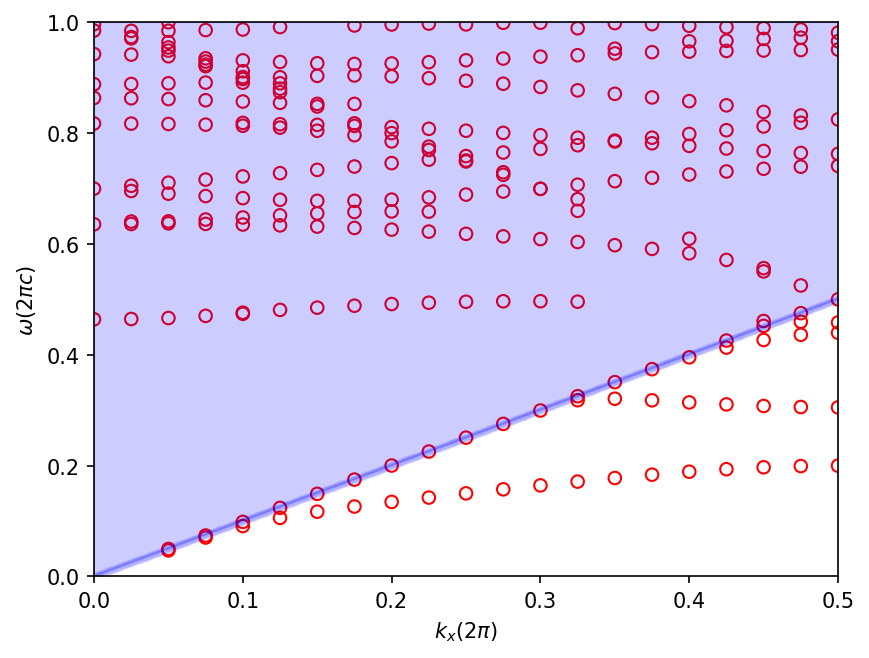

In [122]:
kx = np.linspace(0, 1, 1000)
plt.figure(dpi=150)
plt.scatter(k, w, facecolors='none', edgecolors='r')
plt.scatter(kx, kx, marker='.', color='b', alpha=0.05)
plt.fill_betweenx(kx, 0, kx, color='b', alpha=0.2)
plt.xlim([0,0.5])
plt.ylim([0,1.0])
plt.xlabel('$k_x(2\pi)$')
plt.ylabel('$\omega(2\pi c)$')
plt.savefig('wvg_band.png')
plt.show()

## Investigate several different modes

### $k_x = 0.4$ and $\omega = 0.189$ 

In [5]:
kx = 0.4
sim.k_point = mp.Vector3(kx)
h = mp.Harminv(mp.Hz, mp.Vector3(0.1234), fcen, df)

sim.run(mp.at_beginning(mp.output_epsilon),
        mp.after_sources(h),
        until_after_sources=300)

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00232315 s
Working in 2D dimensions.
Computational cell is 1 x 12 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.01459 s
-----------
Meep: using complex fields.
creating output file "./eps-000000.00.h5"...
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.1889817702712683, -3.2186322829265657e-09, 29357465.16831603, 0.9173628074194488, 0.6215559910258804-0.6747019122963328i, 2.3492082899971334e-09+0.0i
harminv0:, 0.31397716832842415, -4.607660819519691e-08, 3407121.1036010412, 0.16813132374100231, -0.16018625284504415+0.05107353935616089i, 8.56171

In [10]:
fcen = 0.189  # pulse center frequency
df = 0.01     # pulse freq. width: large df = short impulse

src = [mp.Source(mp.GaussianSource(fcen, fwidth=df), component=mp.Hz,
                center=mp.Vector3(0.1234,0))] 
sym = [mp.Mirror(direction=mp.Y, phase=-1)]
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    boundary_layers=pml_layers,
                    sources=src,
                    symmetries=sym,
                    resolution=resolution)
kx = 0.4
sim.k_point = mp.Vector3(kx)
h = mp.Harminv(mp.Hz, mp.Vector3(0.1234), fcen, df)
sim.run(mp.at_beginning(mp.output_epsilon),
        mp.after_sources(h),
        until_after_sources=300)
animate = mp.Animate2D(sim,
                       fields=mp.Hz,
                       realtime=False,
                       normalize=True,
                       field_parameters={'alpha':0.8, 'cmap':'seismic','interpolation':'none'})
sim.run(mp.at_every(1/fcen/20,animate),until=10)
plt.close()

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00090003 s
Working in 2D dimensions.
Computational cell is 1 x 12 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0164979 s
-----------
Meep: using complex fields.
creating output file "./eps-000000.00.h5"...
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.18898181879149548, -3.745986624855261e-14, 2522457201763.199, 188.0466925158425, 187.74002854699603+10.735001039633643i, 4.873266446412834e-13+0.0i
run 0 finished at t = 1300.0 (52000 timesteps)
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,

In [11]:
animate.to_gif(6, 'g_mode_1.gif')

Generating GIF...


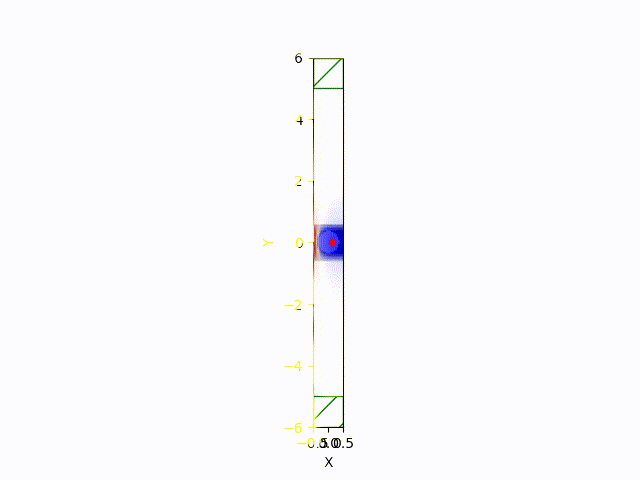

### $k_x = 0.4$ and $\omega = 0.314$

In [12]:
fcen = 0.314  # pulse center frequency
df = 0.01     # pulse freq. width: large df = short impulse

src = [mp.Source(mp.GaussianSource(fcen, fwidth=df), component=mp.Hz,
                center=mp.Vector3(0.1234,0))] 
sym = [mp.Mirror(direction=mp.Y, phase=-1)]
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    boundary_layers=pml_layers,
                    sources=src,
                    symmetries=sym,
                    resolution=resolution)
kx = 0.4
sim.k_point = mp.Vector3(kx)
h = mp.Harminv(mp.Hz, mp.Vector3(0.1234), fcen, df)
sim.run(mp.at_beginning(mp.output_epsilon),
        mp.after_sources(h),
        until_after_sources=300)
animate = mp.Animate2D(sim,
                       fields=mp.Hz,
                       realtime=False,
                       normalize=True,
                       field_parameters={'alpha':0.8, 'cmap':'seismic','interpolation':'none'})
sim.run(mp.at_every(1/fcen/20,animate),until=10)
plt.close()

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.000922918 s
Working in 2D dimensions.
Computational cell is 1 x 12 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0174019 s
-----------
Meep: using complex fields.
creating output file "./eps-000000.00.h5"...
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.31397662389724645, 4.723123701823891e-10, -332382384.7510077, 20.81027972097272, -20.754188564960035-1.5268919657953692i, 9.213801324550074e-13+0.0i
run 0 finished at t = 1300.0 (52000 timesteps)
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,

In [13]:
animate.to_gif(6, 'g_mode_2.gif')

Generating GIF...


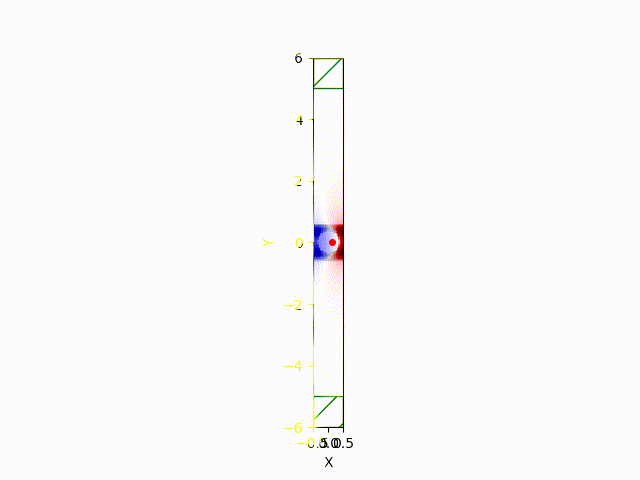

### $k_x = 0.1$ and $\omega = 0.476 - 0.0043i$

In [5]:
kx = 0.1
sim.k_point = mp.Vector3(kx)
h = mp.Harminv(mp.Hz, mp.Vector3(0.1234), fcen, df)

sim.run(mp.at_beginning(mp.output_epsilon),
        mp.after_sources(h),
        until_after_sources=300)

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00236702 s
Working in 2D dimensions.
Computational cell is 1 x 12 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0152409 s
-----------
Meep: using complex fields.
creating output file "./eps-000000.00.h5"...
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.09102546339193313, 0.0008069615246843678, -56.40012603298312, 0.08244888592212749, 0.02452772470703642+0.07871600542771354i, 5.38512115469426e-09+0.0i
harminv0:, 0.09850791894646556, -0.0005594836940638663, 88.0346648093918, 0.009205021273016922, -0.009197556342120295-0.0003706399468713912i, 3.

In [9]:
fcen = 0.476  # pulse center frequency
df = 0.02     # pulse freq. width: large df = short impulse

src = [mp.Source(mp.GaussianSource(fcen, fwidth=df), component=mp.Hz,
                center=mp.Vector3(0.1234,0))] 
sym = [mp.Mirror(direction=mp.Y, phase=-1)]
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    boundary_layers=pml_layers,
                    sources=src,
                    symmetries=sym,
                    resolution=resolution)
kx = 0.1
sim.k_point = mp.Vector3(kx)
h = mp.Harminv(mp.Hz, mp.Vector3(0.1234), fcen, df)
sim.run(mp.at_beginning(mp.output_epsilon),
        mp.after_sources(h),
        until_after_sources=300)
animate = mp.Animate2D(sim,
                       fields=mp.Hz,
                       realtime=False,
                       normalize=True,
                       field_parameters={'alpha':0.8, 'cmap':'seismic','interpolation':'none'})
sim.run(mp.at_every(1/fcen/20,animate),until=10)
plt.close()

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00255418 s
Working in 2D dimensions.
Computational cell is 1 x 12 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0221059 s
-----------
Meep: using complex fields.
creating output file "./eps-000000.00.h5"...
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.47616276248527256, -0.004257139436067863, 55.925201609685075, 0.017880918436371147, -0.017835682429329466+0.0012710926041267264i, 1.2154988880824046e-08+0.0i
run 0 finished at t = 800.0 (32000 timesteps)
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,

In [10]:
animate.to_gif(10, 'l_mode_1.gif')

Generating GIF...


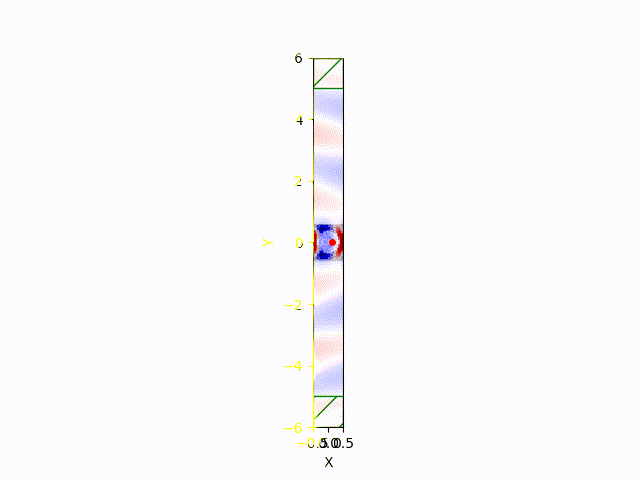

### $k_x = 0.3$ and $\omega = 0.883 - 0.0015i$

In [6]:
kx = 0.3
sim.k_point = mp.Vector3(kx)
h = mp.Harminv(mp.Hz, mp.Vector3(0.1234), fcen, df)

sim.run(mp.at_beginning(mp.output_epsilon),
        mp.after_sources(h),
        until_after_sources=300)

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00293112 s
Working in 2D dimensions.
Computational cell is 1 x 12 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0136402 s
-----------
Meep: using complex fields.
creating output file "./eps-000000.00.h5"...
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.16431782118338023, -1.015032496637751e-07, 809421.4802367192, 0.6764781718477784, 0.6445680228310671-0.20531629484812294i, 1.5993896843358956e-08+0.0i
harminv0:, 0.2993424748567513, 0.000322957282097606, -463.4397356091855, 0.05077534354292403, -0.04741154639895+0.018173628695507364i, 1.5655193

In [7]:
fcen = 0.883  # pulse center frequency
df = 0.03     # pulse freq. width: large df = short impulse

src = [mp.Source(mp.GaussianSource(fcen, fwidth=df), component=mp.Hz,
                center=mp.Vector3(0.1234,0))] 
sym = [mp.Mirror(direction=mp.Y, phase=-1)]
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    boundary_layers=pml_layers,
                    sources=src,
                    symmetries=sym,
                    resolution=resolution)
kx = 0.3
sim.k_point = mp.Vector3(kx)
h = mp.Harminv(mp.Hz, mp.Vector3(0.1234), fcen, df)
sim.run(mp.at_beginning(mp.output_epsilon),
        mp.after_sources(h),
        until_after_sources=300)
animate = mp.Animate2D(sim,
                       fields=mp.Hz,
                       realtime=False,
                       normalize=True,
                       field_parameters={'alpha':0.8, 'cmap':'seismic','interpolation':'none'})
sim.run(mp.at_every(1/fcen/20,animate),until=10)
plt.close()

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00226092 s
Working in 2D dimensions.
Computational cell is 1 x 12 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0175471 s
-----------
Meep: using complex fields.
creating output file "./eps-000000.00.h5"...
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.882974471621921, -0.0015266383327223357, 289.18914607868555, 2.310020706819082, -1.1130431127987168+2.02418642792216i, 1.7608233130921907e-11+0.0i
run 0 finished at t = 633.35 (25334 timesteps)
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1

/home/311514062/anaconda3/envs/mp2/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/311514062/anaconda3/envs/mp2/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Normalizing field data...
run 1 finished at t = 643.35 (25734 timesteps)


In [8]:
animate.to_gif(10, 'l_mode_2.gif')

Generating GIF...


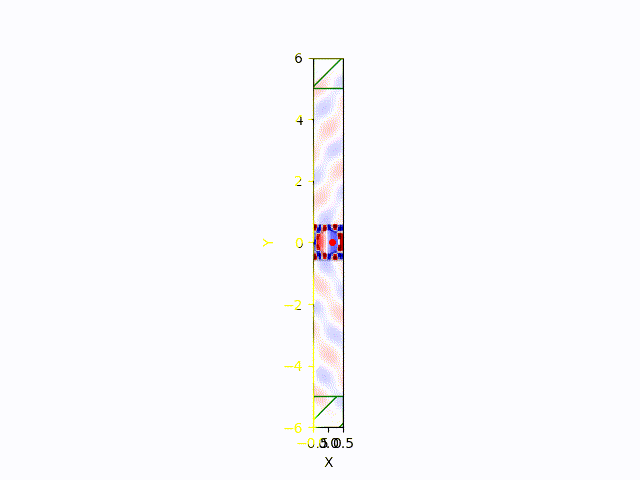

### $k_x = 0.25$ and $\omega = 0.2504 - 0.0008i$

In [5]:
kx = 0.25
sim.k_point = mp.Vector3(kx)
h = mp.Harminv(mp.Hz, mp.Vector3(0.1234), fcen, df)

sim.run(mp.at_beginning(mp.output_epsilon),
        mp.after_sources(h),
        until_after_sources=300)

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00188088 s
Working in 2D dimensions.
Computational cell is 1 x 12 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0136569 s
-----------
Meep: using complex fields.
creating output file "./eps-000000.00.h5"...
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.14989884260135147, 1.660230905230277e-07, -451439.74289696844, 0.5639901754367063, 0.5639813381977131-0.0031572383254043625i, 1.5810508476370655e-08+0.0i
harminv0:, 0.25039364560134686, -0.000798247613992297, 156.8395828639227, 0.015625672676023647, -0.014671185010741866+0.005377543766331913i, 

In [6]:
fcen = 0.25  # pulse center frequency
df = 0.01     # pulse freq. width: large df = short impulse

src = [mp.Source(mp.GaussianSource(fcen, fwidth=df), component=mp.Hz,
                center=mp.Vector3(0.1234,0))] 
sym = [mp.Mirror(direction=mp.Y, phase=-1)]
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    boundary_layers=pml_layers,
                    sources=src,
                    symmetries=sym,
                    resolution=resolution)
kx = 0.25
sim.k_point = mp.Vector3(kx)
h = mp.Harminv(mp.Hz, mp.Vector3(0.1234), fcen, df)
sim.run(mp.at_beginning(mp.output_epsilon),
        mp.after_sources(h),
        until_after_sources=300)
animate = mp.Animate2D(sim,
                       fields=mp.Hz,
                       realtime=False,
                       normalize=True,
                       field_parameters={'alpha':0.8, 'cmap':'seismic','interpolation':'none'})
sim.run(mp.at_every(1/fcen/20,animate),until=10)
plt.close()

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00159407 s
Working in 2D dimensions.
Computational cell is 1 x 12 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0166709 s
-----------
Meep: using complex fields.
creating output file "./eps-000000.00.h5"...
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.2503956385393274, -0.000794471392337473, 157.58631522440342, 0.21440795365208584, 0.17095201194287996+0.12940703304672593i, 4.680886435812482e-10+0.0i
run 0 finished at t = 1300.0 (52000 timesteps)
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0

/home/311514062/anaconda3/envs/mp2/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/311514062/anaconda3/envs/mp2/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


run 1 finished at t = 1310.0 (52400 timesteps)


In [7]:
animate.to_gif(10, 'e_mode.gif')

Generating GIF...


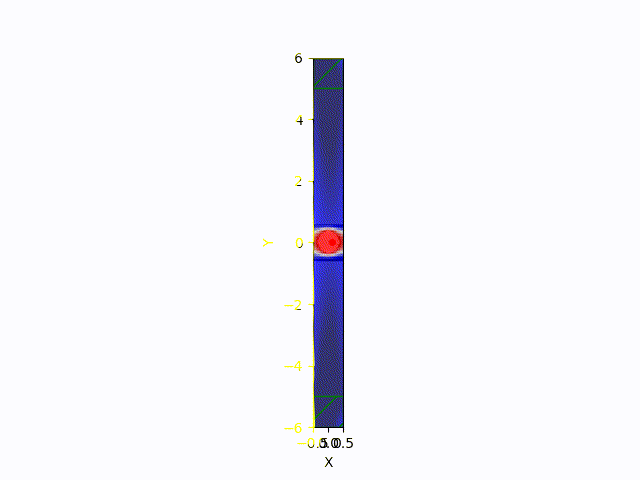

### $k_x = 0.3$ and $\omega = 0.1643177236748588$

In [16]:
fcen = 0.16431780033900795  # pulse center frequency
df = 0.02     # pulse freq. width: large df = short impulse
src = [mp.Source(mp.GaussianSource(fcen, fwidth=2*df), component=mp.Hz,
                center=mp.Vector3(0.1234,0))]
sym = [mp.Mirror(direction=mp.Y, phase=-1)]
geometry = [b,c]
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    boundary_layers=pml_layers,
                    sources=src,
                    symmetries=sym,
                    resolution=resolution)
kx = 0.3
sim.k_point = mp.Vector3(kx)
h = mp.Harminv(mp.Hz, mp.Vector3(0.1234), fcen, df)

sim.run(mp.at_beginning(mp.output_epsilon),
        mp.after_sources(h),
        until_after_sources=1000)
animate = mp.Animate2D(sim,
                       fields=mp.Hz,
                       realtime=False,
                       normalize=True,
                       field_parameters={'alpha':0.8, 'cmap':'seismic','interpolation':'none'})
sim.run(mp.at_every(1/fcen/20,animate),until=100)
plt.close()

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.000849009 s
Working in 2D dimensions.
Computational cell is 1 x 20 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0226111 s
-----------
Meep: using complex fields.
creating output file "./eps-000000.00.h5"...
Meep progress: 1118.625/1250.0 = 89.5% done in 4.0s, 0.5s to go
on time step 44777 (time=1119.42), 8.93321e-05 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.16431771371891363, 5.795677419587342e-14, -1417588504525.6125, 41.159312514020364, 39.884464637453675-10.164570193102142i, 1.4156510815367149e-13+0.0i
run 0 finished at t = 125

In [17]:
animate.to_gif(10, 'nq_mode.gif')

Generating GIF...


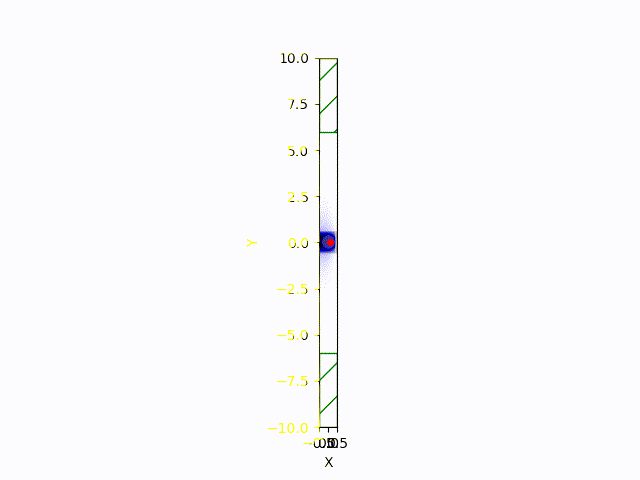